In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime as dt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

C:\Users\Eduardo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Eduardo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Eduardo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Eduardo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarnin

In [2]:
data = pd.read_excel('dolartoday.xlsx')

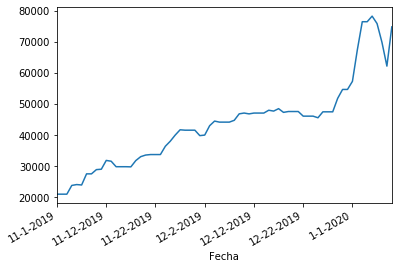

In [3]:
data.head()
dates = data['Fecha']
prices = data['DolarToday']

idx_train_start = data[data['Fecha'] == '11-1-2019'].index[0] # 1 de Noviembre de 2019
idx_train_end = data[data['Fecha'] == '12-31-2019'].index[0] # 31 de Diciembre de 2019
idx_test_start = idx_train_end + 1
idx_test_end = len(data)

data = data.iloc[idx_train_start:idx_test_end,:]

uni_data = data['DolarToday']
uni_data.index = data['Fecha']


uni_data.plot(subplots = True)


uni_data_mean = uni_data.mean()
uni_data_std = uni_data.std()

# Normalize
uni_data = (uni_data - uni_data_mean)/uni_data_std

In [4]:
X = np.array(uni_data.index)
Y = np.array(uni_data.values)
X = [dt.datetime.strptime(date, '%m-%d-%Y').timestamp() for date in X]


In [5]:
# Normalize X
X = pd.DataFrame(X)
X = (X - X.mean())/(X.max() - X.min())
X = np.array(X)


In [6]:
N_train = idx_train_end - idx_train_start
N_test = idx_test_end - idx_test_start

idx_train_start = 0
idx_train_end = idx_train_start + N_train
idx_test_start = idx_train_end
idx_test_end = idx_test_start + N_test


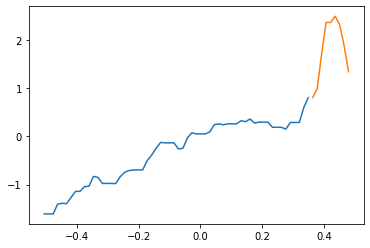

In [16]:
X_train = X[idx_train_start:idx_train_end]
X_test = X[idx_test_start:idx_test_end]

Y_train = Y[idx_train_start:idx_train_end]
Y_test = Y[idx_test_start:idx_test_end]

X_train = X_train.reshape((len(X_train),1))
Y_train = Y_train.reshape((len(Y_train),1))

X_test = X_test.reshape((len(X_test),1))
Y_test = Y_test.reshape((len(Y_test),1))
plt.plot(X_train, Y_train, label='Train')
plt.plot(X_test, Y_test,label='Test')

In [17]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


<DatasetV1Adapter shapes: ((1,), (1,)), types: (tf.float64, tf.float64)>


In [10]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(8, input_shape=X_train.shape[-2:]),
        tf.keras.layers.Dense(1)
    ]
)

model.compile(optimizer='adam', loss='mae')
#model.fit((X_train, Y_train), epochs=200)
model.fit(train_univariate, epochs=200,
                      steps_per_epoch=100,
                      validation_data=val_univariate, validation_steps=50)

ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (None, 1)

In [85]:
res = model.predict(x_test)*(np.max(prices) - np.min(prices)) + np.min(prices)
y_test = y_test * (np.max(prices) - np.min(prices)) + np.min(prices)
print('Predicted value is: {0:.6f} and real value is {1:.6f}'.format(res[0][0], y_test[0][0]))

Predicted value is: 4262.421387 and real value is 74842.720000
